In [301]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import random

In [302]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [303]:
# build the vocapbulary of charactors mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print (itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [304]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X, dtype=jnp.int32)
    Y = jnp.array(Y, dtype=jnp.int32)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


(182625, 3) (182625,)
(22655, 3) (22655,)
(22866, 3) (22866,)


In [305]:
# Set master seed and key from beginning
seed = 1701
key = jax.random.PRNGKey(seed)

# MLP Model
n_embd = 10
n_hidden = 200

# Embedding Matrix
key, C_key = jax.random.split(key)
C = jax.random.normal(C_key, (vocab_size, n_embd), dtype=jnp.float32)

# First layer weights
key, W1_key, b1_key = jax.random.split(key,num=3)
W1 = jax.random.normal(W1_key, (n_embd * block_size, n_hidden), dtype=jnp.float32)/(n_embd * block_size)**0.5
b1 = jax.random.normal(b1_key, (n_hidden, ), dtype=jnp.float32)*0.01

# Second layer weights
key, W2_key, b2_key = jax.random.split(key,num=3)
W2 = jax.random.normal(W2_key, (n_hidden, vocab_size), dtype=jnp.float32)/n_hidden**0.5
b2 = jax.random.normal(b2_key, (vocab_size, ), dtype=jnp.float32)*0.01

#params = [C, W1, b1, W2, b2]
params = dict(C=C, W1=W1, b1=b1, W2=W2, b2=b2)

#print (params)

#print(f'Network parameter size is: {sum(p.size for p in params)}')

print(f'{Xtr.shape = }')
print(f'{C.shape = }')
print(f'{C[Xtr].shape = }')


Xtr.shape = (182625, 3)
C.shape = (27, 10)
C[Xtr].shape = (182625, 3, 10)


In [306]:
# Training loop
max_steps = 40000
batch_size = 64
lossi = []


def forward(params, X):

        # forward pass
    emb = params['C'][X]
    embcat = emb.reshape(emb.shape[0], -1)

    hpreact = embcat @ params['W1'] + params['b1']
    #hpreact = bngain*(hpreact - bnmeanr)/bnstdr + bnbias

    h = jnp.tanh(hpreact)
    logits = h @ params['W2'] + params['b2']
    return logits

def softmax_cross_entropy(logits,targets):
   
    # Get Log probabilities 
    lprobs = jax.nn.log_softmax(logits)
    
    # Average loss per target
    loss = -jnp.mean(lprobs[jnp.arange(logits.shape[0]), targets])

    return loss


def get_loss(params, X, Y, regularization=True):

    # Get logits
    logits = forward(params, X)
    
    
    # Get loss
    loss = softmax_cross_entropy(logits, Y) 

    if regularization == True:
        pen = 0.00001
        loss += pen*jnp.sum(params['W1']**2) + pen*jnp.sum(params['W1']**2)

    return loss

    

for i in range(max_steps):

    # minibatch construct
    key, ix_key = jax.random.split(key)
    ix = jax.random.randint(ix_key, (batch_size, ),
                            minval=0, maxval=Xtr.shape[0], dtype=jnp.int32)
    Xb, Yb = Xtr[ix], Ytr[ix]

    loss = get_loss(params, Xb, Yb)

    grads = jax.grad(get_loss)(params, Xb, Yb)

    #loss = -jnp.mean(loss1[jnp.arange(Xb.shape[0], Yb)])

    lr = 0.1 if i < max_steps/2 else 0.01
    params = jax.tree_map(lambda p, g: p - lr * g, params, grads)


    NN = int(max_steps/20)
    lossi.append(loss)
    if i % NN == 0:
        aloss = jnp.mean(jnp.array(lossi[-NN:]))
        print(f'{i:7d}/{max_steps:7d}: loss = {aloss:.4f}')


    #break


      0/  40000: loss = 3.3785
   2000/  40000: loss = 2.4202
   4000/  40000: loss = 2.2946
   6000/  40000: loss = 2.2615
   8000/  40000: loss = 2.2318
  10000/  40000: loss = 2.2174
  12000/  40000: loss = 2.2028
  14000/  40000: loss = 2.1930
  16000/  40000: loss = 2.1895
  18000/  40000: loss = 2.1715
  20000/  40000: loss = 2.1724
  22000/  40000: loss = 2.1141
  24000/  40000: loss = 2.1098
  26000/  40000: loss = 2.1150
  28000/  40000: loss = 2.1200
  30000/  40000: loss = 2.1107
  32000/  40000: loss = 2.1089
  34000/  40000: loss = 2.1081
  36000/  40000: loss = 2.1103
  38000/  40000: loss = 2.1077


In [309]:
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    # forward pass
    emb = params['C'][x]
    embcat = emb.reshape(emb.shape[0], -1)

    hpreact = embcat @ params['W1'] + params['b1']
    #hpreact = bngain*(hpreact - bnmeanr)/bnstdr + bnbias

    h = jnp.tanh(hpreact)
    logits = h @ params['W2'] + params['b2']
    loss = softmax_cross_entropy(logits,y)
    
    print(f'{split:5s} loss = {loss.item():.4f}')


split_loss('train')
split_loss('val')

train loss = 2.0966
val   loss = 2.1314


In [308]:
seed = 42
key = jax.random.PRNGKey(seed)


for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        
        logits = forward(params, jnp.array([context]))

        key, ix_key = jax.random.split(key)
        ix = jax.random.categorical(ix_key,logits).item()

        # Uniform logits to compare with
        #ix = jax.random.categorical(ix_key,jnp.ones(logits.shape)).item()

        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))




koeanleynne.
stel.
arwi.
sanie.
elszin.
kayneya.
bena.
jamyike.
holy.
kaieana.
peanahani.
emahonielilan.
hcce.
eleslynn.
cohiefe.
ghon.
cani.
carrossiyah.
hilah.
chris.


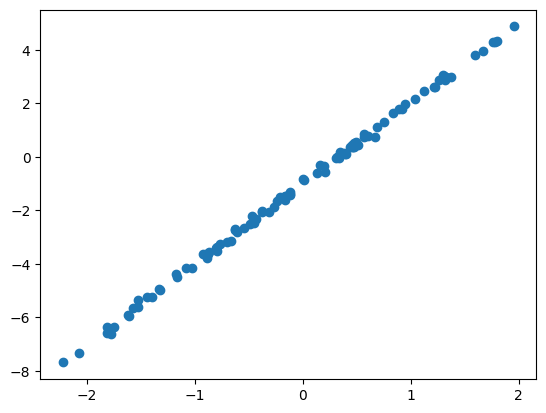

In [313]:
key, x_key = jax.random.split(key)
xs = jax.random.normal(x_key, (100,), dtype=jnp.float32)

key, n_key = jax.random.split(key)
noise = jax.random.normal(n_key, (100,), dtype=jnp.float32)*0.1
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

w: 3.01, b: -1.00


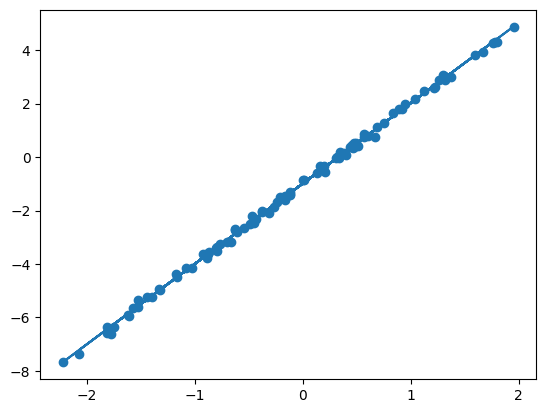

In [335]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")


w: 3.01, b: -1.00


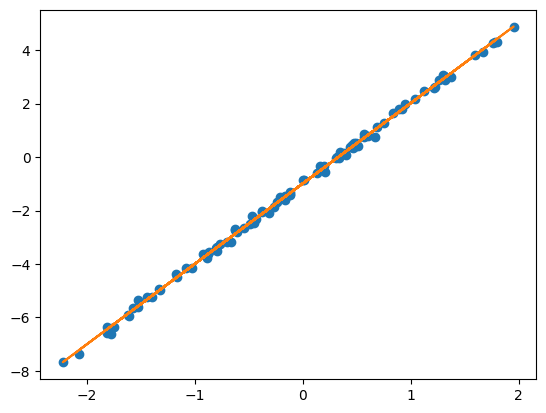

In [342]:
class Linear:
    def __init__(self):
        self.w = 1.0
        self.b = 1.0

    def params(self):
        return jnp.array([self.w, self.b])

    def __call__(self,params,x):
        w, b = params
        return w * x + b

    def loss_fn(self,params, x, y):
        prediction = self(params, x)
        return jnp.mean((prediction-y)**2)

    def update(self, params, x, y, lr=0.1):
 
        return params - lr*jax.grad(self.loss_fn)(params, x, y)



lin1 = Linear()
params = lin1.params()
params
for _ in range(1000):
  params = lin1.update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, lin1(params, xs),'C1-')

w, b = params
print(f"w: {w:<.2f}, b: {b:<.2f}")

weight shape:  (1, 128)
weight shape:  (128, 128)
weight shape:  (1, 128)
weight shape:  (128, 128)


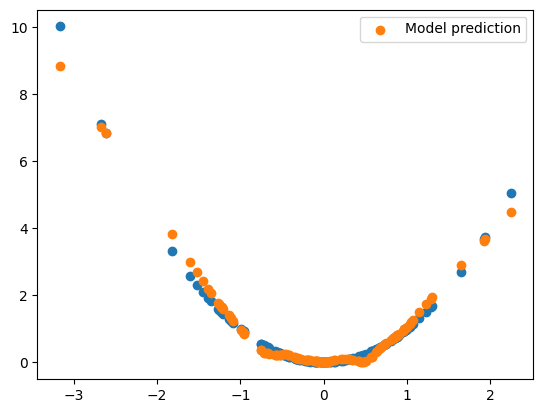

In [423]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    print ('weight shape: ', layer['weights'].shape)
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

  import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(10000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

In [356]:
key

Array([2155871949, 1453605664], dtype=uint32)

Model layer 0 has params: ['weights', 'bias']
Model layer 1 has params: ['p']
Model layer 2 has params: ['weights', 'bias']
Model layer 3 has params: ['p']
Model layer 4 has params: ['weights', 'bias']


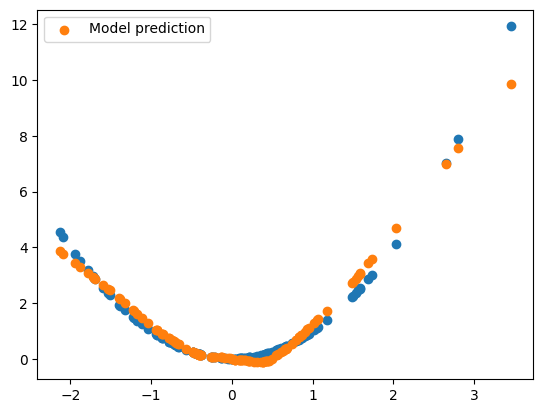

In [576]:
# Solve Jax example problem with model and layer classes

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # State of layer
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.bias = bias

    def init(self, key):

        key, w_key, b_key = jax.random.split(key, num=3)

        # The Weight matrix should be (fan_out, fan_in) and the linear
        # product should be x*W.T + b. However, W.T is indistiguishable
        # from W(fan_in, fan_out) at initialization time. So init as such.
        w = jax.random.normal(w_key, (self.fan_in, self.fan_out),
                              dtype=jnp.float32)*(2.0/self.fan_in)**0.5
        b = jax.random.normal(b_key, (self.fan_out,),
                              dtype=jnp.float32)  # /self.fan_out**0.5

        # Layer parameters
        params = dict(weights=w, bias=b)

        return key, params

    # Call for network
    def __call__(self, params, X):
        self.out = X @ params['weights'] + params['bias']
        return self.out

class Relu:
    def __call__(self, params, x):
        self.out = jax.nn.relu(x)
        return self.out

    def init(self, key):
        return key, dict(p = None)


# Set master seed and key from beginning
seed = 1701
key = jax.random.PRNGKey(seed)
inits = [1, 128, 128,  1]
params = {}
net = []

n_in = 1
n_h = 128
n_out = 1

layers = [Linear(n_in, n_h), Relu(), Linear(n_h, n_h), Relu(), Linear(n_h, n_out)]




for i, layer in enumerate(layers):
    key, params[i] = layer.init(key)


tot = 0
for l in range(len(params)):
    print(f'Model layer {l} has params: {list(params[l].keys())}')


def forward(params, net, x):

    # Put all layers in layers except the last
    for i, layer in enumerate(layers):
        # print (i, x.shape)
        x = layer(params[i], x)

    return x


def loss_fn(params, net, x, y):
    return jnp.mean((forward(params, net, x) - y) ** 2)


lr = 0.0001


def update(params, net, x, y):

    # Get grads
    grads = jax.grad(loss_fn)(params, net, x, y)

    # Apply the SGD update using tree utils:
    return jax.tree_map(lambda p, g: p - lr * g, params, grads)


xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(2000):
    # print (params[0]['weights'])
    params = update(params, net, xs, ys)
    # print (params[0]['weights'])

plt.scatter(xs, ys)
# print (forward(params, net, xs).shape)
plt.scatter(xs, forward(params, net, xs), label='Model prediction')
plt.legend()



* Layer 0 has params:  (1, 128) weights,  (128,) bias, 
* Layer 1 has params:  None
* Layer 2 has params:  (128, 128) weights,  (128,) bias, 
* Layer 3 has params:  None
* Layer 4 has params:  (128, 128) weights,  (128,) bias, 
* Layer 5 has params:  None
* Layer 6 has params:  (128, 1) weights,  (1,) bias, 

* A total of 33409 prameters

* Epoch:     0/ 1000, loss = 62.73883056640625
* Epoch:   100/ 1000, loss = 0.0993121862411499
* Epoch:   200/ 1000, loss = 0.05843636393547058
* Epoch:   300/ 1000, loss = 0.04256588965654373
* Epoch:   400/ 1000, loss = 0.03230884298682213
* Epoch:   500/ 1000, loss = 0.025305800139904022
* Epoch:   600/ 1000, loss = 0.02054450660943985
* Epoch:   700/ 1000, loss = 0.01703464984893799
* Epoch:   800/ 1000, loss = 0.014255687594413757
* Epoch:   900/ 1000, loss = 0.012241631746292114


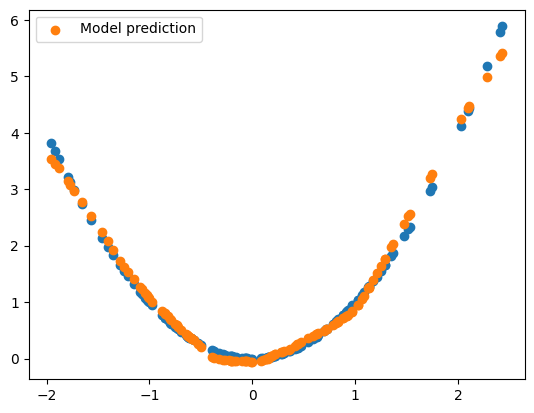

In [625]:
import matplotlib.pyplot as plt


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # State of layer
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.bias = bias

    def init(self, key):

        key, w_key, b_key = jax.random.split(key, num=3)

        # The Weight matrix should be (fan_out, fan_in) and the linear
        # product should be x*W.T + b. However, W.T is indistiguishable
        # from W(fan_in, fan_out) at initialization time. So init as such.
        w = jax.random.normal(w_key, (self.fan_in, self.fan_out),
                              dtype=jnp.float32)*(2.0/self.fan_in)**0.5
        b = jax.random.normal(b_key, (self.fan_out,),
                              dtype=jnp.float32)  # /self.fan_out**0.5

        # Layer parameters
        params = dict(weights=w, bias=b)

        return key, params

    # Call for network
    def __call__(self, params, X):
        self.out = X @ params['weights'] + params['bias']
        return self.out


class Relu:
    def __call__(self, params, x):
        self.out = jax.nn.relu(x)
        return self.out

    def init(self, key):
        return key, dict(p=None)


class Model:
    def __init__(self, layers):
        pass


class Sequential(Model):
    def __init__(self, layers):
        self.layers = layers

    def __repr__(self):
        my_repr = '\n'
        totl = 0
        for l in range(len(params)):
            my_repr += f'* Layer {l} has params: '
            for key in params[l].keys():
                if params[l][key] == None:
                    my_repr += f' {params[l][key]}'
                else:
                    totl += jnp.array(params[l][key]).size
                    shape = jnp.array(params[l][key]).shape
                    my_repr += f' {shape} {key}, '
            my_repr +='\n'
        my_repr += f'\n* A total of {totl} prameters\n'
        return my_repr

    def init(self, key):
        for i, layer in enumerate(self.layers):
            key, params[i] = layer.init(key)

        tot = 0
        #for l in range(len(params)):
        #    print(f'Model layer {l} has params: {list(params[l].keys())}')

        return params

    # def forward(self, params, layers, x):
    def __call__(self, params, layers, x):

        # Put all layers in layers except the last
        for i, layer in enumerate(layers):
            # print (i, x.shape)
            x = layer(params[i], x)

        return x

    def loss_fn(self, params, layers, x, y):
        return jnp.mean((self(params, layers, x) - y) ** 2)

    def update(self, params, layers, x, y, lr):

        # Get grads
        loss, grads = jax.value_and_grad(self.loss_fn)(params, layers, x, y)

        # Apply the SGD update using tree utils:
        return jax.tree_map(lambda p, g: p - lr * g, params, grads), loss

    def train(self, params, x, y, n_steps=1, lr=0.01, ploss=100):
        for i in range(n_steps):
            params, loss = self.update(params, self.layers, x, y, lr)
            if i % ploss == 0:
                print (f'* Epoch: {i:5d}/{n_steps:5d}, loss = {loss.item()}')
        return params

    def apply(self, params, x):
        y = self(params, self.layers, x)
        return y


# Data to fit
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

# Set master seed and key from beginning
seed = 1701
key = jax.random.PRNGKey(seed)
n_i = 1
n_h = 128
n_o = 1


model = Sequential([Linear(n_i, n_h), Relu(),
                    Linear(n_h, n_h), Relu(),
                    Linear(n_h, n_h), Relu(),
                    Linear(n_h, n_out)])
params = model.init(key)
print (model)
params = model.train(params, xs, ys, n_steps=1000, lr=0.0001)
y = model.apply(params, xs)

plt.scatter(xs, ys)
plt.scatter(xs, y, label='Model prediction')
plt.legend();


In [351]:
class Linear:
    def __init__(self, key, fan_in, fan_out, bias=True):
        # State of layer
        self.key = key
        key, w_key, b_key = jax.random.split(self.key, num=3)

        # Weights of layer
        self.w = jax.random.normal(
            w_key, (fan_out, fan_in), dtype=jnp.float32)/fan_in**0.5
        self.b = jax.random.normal(w_key, (fan_out,), dtype=jnp.float32)*0.01

    # Layer parameters
    def params(self):
        params = dict(weights=self.w, bias=self.b)
        return params

    # Call for network
    def __call__(self, params, X):
        self.out = params['weights'] @ X + params['bias']
        return self.out



inits = [1, 128, 128, 1]
for i, n_in in enumerate(inits[:-1]):
    
    print (i, n_in)





'''

layer1 = Linear()

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

  import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();
''';



0 1
1 128
2 128


In [346]:
w = 1
b = 2
p = {'w':w, 'b':b}
print (p)

{'w': 1, 'b': 2}


In [ ]:
for i in range(10):
    